# THE IDEA
This project aims to embed Magic: The Gathering (MTG) cards into a vector space in a way that preserves their playstyle, so that cards with similar gameplay mechanics end up close to each other, and cards with different mechanics are placed farther apart.

Once this embedding is achieved, the goal is to cluster the card representations to find out whether the [color pie](https://www.mtgsalvation.com/articles/features/guides/49791-a-guide-to-magic-the-gatherings-color-wheel-new) is preserved, in other words whether cards of the same color tend to group together in the embedding space, while remaining distinct from cards of other colors.\
After collecting data from Scryfall, various embedding and clustering techniques will be explored, as well as dimensionality reduction methods to make the results easier to visualize in plots.\
In this notebook, the methods will be tested and reported in the order I decided to implement them, starting with simple approaches and gradually moving on to more advanced ones.

After a brief search, I found that others have already explored this area (see [alexlyman.org](https://alexlyman.org/blog/color_pAI.html) and [minimaxir’s GitHub project](https://github.com/minimaxir/mtg-embeddings)). Before looking in detail at what they did, I want to try and see how far I can go on my own.

# DATA IMPORT AND CLEANING

Data for this project is retrieved from [Scryfall API](https://scryfall.com/docs/api), which is periodically updated with newer cards.

I downloaded a JSON file containing every card object on Scryfall (~490MB) using the default language (English) or the printed language if the card is only available in that one.

The dataset is filtered to remove:
- Basic lands
- Tokens
- Cards with no rules text and zero converted mana cost (CMC)
- Cards not printed in paper format
- Non-English cards
- Cards not meant for structured play (mostly un-sets)

Colorless cards (such as Eldrazi or some artifacts) are kept in this filtered dataset for potential future use. A separate function will later extract only monocolored cards, which will be the working dataset for this notebook. Multi-faced cards are merged into a single cardto be a bit easyer to handle later on.\
Note that the same card may appear multiple times in the dataset, since I'm interested in analyzing clusters of cards in different years, and reprints are a common thing in MTG.

In [1]:
from code.data_handler import *
from pathlib import Path # Used to get absolute paths to data files;
                         # __file__ variable is not defined in interactive environments, cannot use os library

In [2]:
# Paths that will be used from now on
raw_data = (Path("data") /  "raw_cards.json").resolve()
clean_data = (Path("data") /  "clean_cards.json").resolve()
monocol_data = (Path("data") /  "monocol.json").resolve()

In [12]:
# In this cell we decide wether to download new fresher data from scryfall, in which case the data is also preprocessed
# An additional check is added, to make sure we don't overwrite previous data by mistake
if input("Download fresher data? (Y/N): ").strip().lower() == "y":
    download_data(raw_data)
    filter_data(raw_data, clean_data, show = True)
else:
    print("Download avoided.")


Fetching latest bulk metadata...
https://data.scryfall.io/default-cards/default-cards-20250720091037.json
Download complete.
Applying filters...
Filtering completed.


In [13]:
# Let's see what we're working with
import pandas as pd
df = pd.read_json(clean_data)
df.head(5)

,id,oracle_id,name,released_at,mana_cost,type_line,oracle_text,colors,color_identity,keywords,set,set_name
0,0000579f-7b35-4ed3-b44c-db2a538066fe,44623693-51d6-49ad-8cd7-140505caf02f,Fury Sliver,2006-10-06,{5}{R},Creature — Sliver,All Sliver creatures have double strike.,[R],[R],[],tsp,Time Spiral
1,00006596-1166-4a79-8443-ca9f82e6db4e,8ae3562f-28b7-4462-96ed-be0cf7052ccc,Kor Outfitter,2009-10-02,{W}{W},Creature — Kor Soldier,"When this creature enters, you may attach targ...",[W],[W],[],zen,Zendikar
2,0000cd57-91fe-411f-b798-646e965eec37,9f0d82ae-38bf-45d8-8cda-982b6ead1d72,Siren Lookout,2017-09-29,{2}{U},Creature — Siren Pirate,"Flying\nWhen this creature enters, it explores...",[U],[U],"[Flying, Explore]",xln,Ixalan
3,00012bd8-ed68-4978-a22d-f450c8a6e048,5aa12aff-db3c-4be5-822b-3afdf536b33e,Web,1994-04-11,{G},Enchantment — Aura,Enchant creature (Target a creature as you cas...,[G],[G],[Enchant],3ed,Revised Edition
4,0001b4a6-10bf-4bdd-a9da-fe78d9d39a82,c6e0574c-3e2b-4c40-b17a-05bce3d49309,Wastewood Verge,2025-02-14,,Land,{T}: Add {G}.\n{T}: Add {B}. Activate only if ...,[],"[B, G]",[],pdft,Aetherdrift Promos


In [14]:
# Here we create the dataset we will work with
# Decided to filter monocolored cards trough color (not color_identity)
get_monocolored_cards(clean_data, monocol_data)
print("Monocolored cards extracted in 'monocol.json'")

Monocolored cards extracted in 'monocol.json'


Let's see how many cards we got left:

In [15]:
count_cards(monocol_data)

Reading data...
Total cards: 45926
Monocolored cards: 45926 (100.00%)
Multicolored cards: 0 (0.00%)



# EMBEDDING CARDS IN VECTOR SPACE

some of the sites i looked into:
- [cross encoders and bi-encoders](https://medium.com/@rbhatia46/cross-encoders-vs-bi-encoders-a-deep-dive-into-text-encoding-methods-d9aa890d6ca4)
- [sentence embeddings](https://osanseviero.github.io/hackerllama/blog/posts/sentence_embeddings/#selecting-and-evaluating-models)
- [embedding models leaderboard](https://huggingface.co/spaces/mteb/leaderboard)
- [model search in huggingface](https://huggingface.co/models?library=sentence-transformers,pytorch&sort=trendin)
- [sentence transformer documentation](https://www.sbert.net/)
- [pretrained models performance](https://www.sbert.net/docs/pretrained_models.html#mpnet-models)

To represent cards in a semantic vector space, I will use the following pre-trained models from the SentenceTransformers library:

- all-MiniLM-L6-v2 (~384MB)\
    A lightweight and efficient model offering a good trade-off between speed and performance. It will serve as a baseline for comparison.

- all-mpnet-base-v2(~768MB)\
    A larger, more accurate model that captures richer semantic information. It provides higher-quality embeddings at the cost of increased computational time and memory usage.

These models will be used to encode the card texts into fixed-size embeddings, which will then be used for clustering based on gameplay semantics.

The text used for embeddings is fixed, each card will be represented by the following fields:
- type line
- keywords (for redundancy)
- oracle text

In [3]:
from code.embeddings import create_embeddings

In [17]:
for model in ["all-MiniLM-L6-v2", "all-mpnet-base-v2"]:
    print(f"Now embedding using model {model}")
    emb_path = (Path("data") / model / "monocol_emb.pkl").resolve()
    create_embeddings(monocol_data, emb_path, model)
    print('Embeddings saved successfully.\n')

Now embedding using model all-MiniLM-L6-v2


Batches:   0%|          | 0/1436 [00:00<?, ?it/s]

Embeddings saved successfully.

Now embedding using model all-mpnet-base-v2


Batches:   0%|          | 0/1436 [00:00<?, ?it/s]

Embeddings saved successfully.



# CLUSTERING AND DIMENSIONALITY REDUCTION

Idea, inspired by [this](https://www.geeksforgeeks.org/machine-learning/what-are-the-best-practices-for-clustering-high-dimensional-data/):\
apply dimensionality reduction to allow for more effective clustering, and then try out different clustering algorithms. Trough cluster validation verify the effectiveness of clusters.\
Later reduce imensionality so that results can be visualized in a plot.

UMAP:\
[explanation](https://biostatsquid.com/umap-simply-explained/); [documentation](https://umap-learn.readthedocs.io/en/latest/)

HDBSCAN:\
sklearn [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.HDBSCAN.html)

After a fast check, we can see how the first model creates embeddings of dimension 384, the second model instead goes up to dimension 768. This means that clustering performance may be affected by the "curse of dimensionality", which makes distance metrics less informative and increases the computational cost of algorithms. Before we move on to the actual clustering algorithm, data dimension will be reduced, then the clustering algorithm will wee applied, and in the end clustered data will be reduced again to a dimension that can be plotted, to see the results.

The data in this section in composed of embeddings that represent the semantic meaning of the original cards. For this reason, i will not apply standardization (which treats directions indipendently and could damage the information of the embeddings), But i will apply a L2 normalization to all vectors (keeping directions of vectors) and see if this idea improves the following clustering.

In [4]:
from code.clustering import *

Unique filtered cards printed in 2017 are: 1606
Performing dimensionality reduction with UMAP...


c:\Users\test1\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Clustering the reduced data with HDBSCAN...

--- Clustering Validation Results ---
Number of clusters found (excluding noise): 14
Fraction of noise points: 355 / 1606
Adjusted Rand Index (ARI): 0.0519
Normalized Mutual Information (NMI): 0.1175
Homogeneity: 0.1515
Completeness: 0.0959
V-Measure: 0.1175

Contingency Matrix (rows=true, cols=predicted):
[[ 6 30 10 19 28 15 11 32 32 50  3 11 19  4]
 [14 13 24 27  0 12 11 24  7 12 27 41 34  2]
 [ 9  3  2 24  4 53 11 20 25  2  2  7 29 56]
 [12 23  9 29  3  2 11 68 39  1  4 24 15  2]
 [ 8  5  1 31  9 19 18 24 51 29  9 16 24  0]]
--- End of Validation Report ---

Creating a 2D embedding for visualization...


c:\Users\test1\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


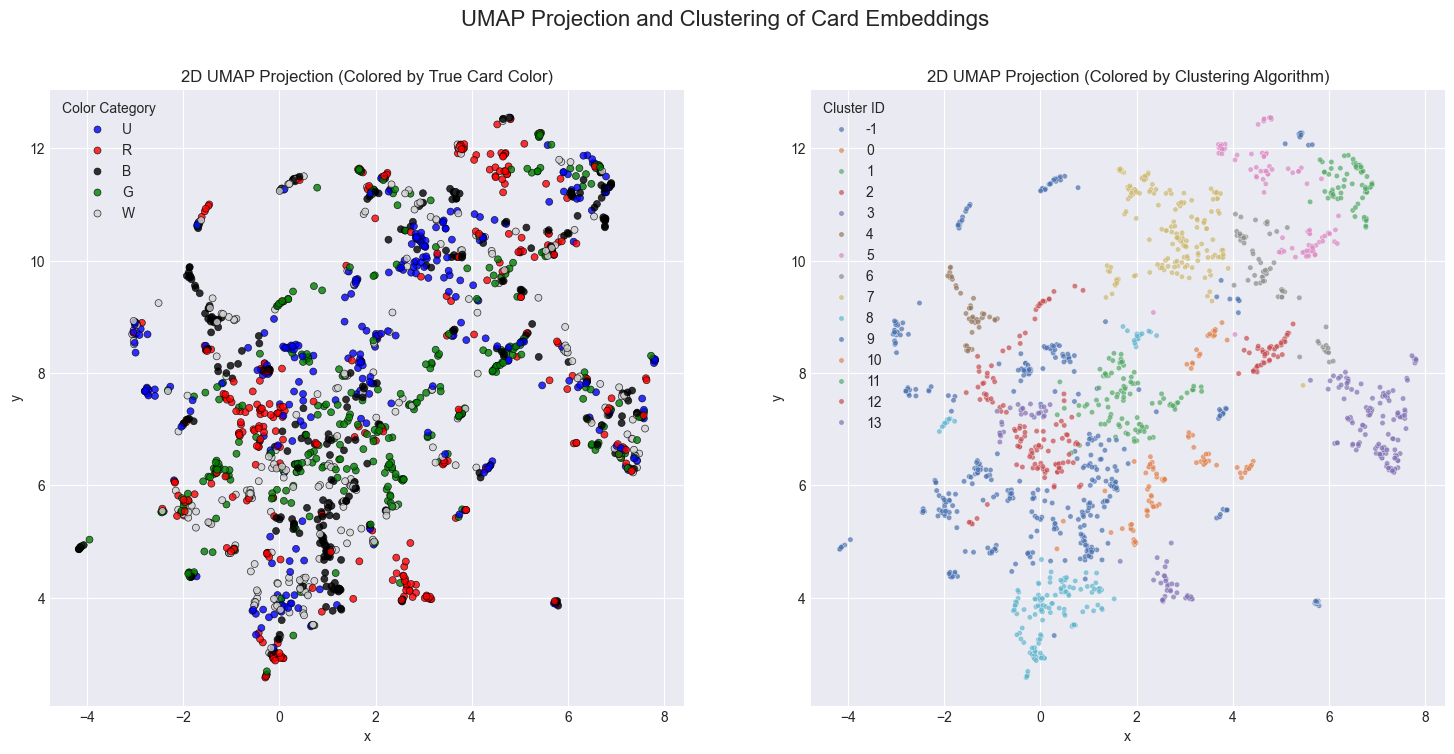

In [36]:
emb_path = (Path("data") / "all-mpnet-base-v2" / "monocol_emb.pkl").resolve()
year = 2017
normalize = True
n_neigh_umap = 12
umap_components = 5
umap_metric = 'cosine'
hdbscan_min_cl_size=40
hdbscan_min_samples=5
hdbscan_eps=0.0

hdbscan_clustering(emb_path, year, normalize, n_neigh_umap, umap_components, umap_metric, hdbscan_min_cl_size, hdbscan_min_samples, hdbscan_eps)

Trying out different parameters, I see how increasing the dimension in which the clustering algorithm is computed, the clusters hdbscan finds become less diverse, merging together and becoming incapable of finding the original structure.

At this point, one possibility is to keep experimenting with the parameters of hdbscan, but i decided to try out another clustering algorithm where i can specify the numer of clusters i want to be found, and which should be able to find non convex clusters.

Unique filtered cards printed in 2017 are: 1606
Performing dimensionality reduction with UMAP...


c:\Users\test1\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Clustering the reduced data with Spectral Clustering...

--- Clustering Validation Results ---
Number of clusters found (excluding noise): 5
Fraction of noise points: 0 / 1606
Adjusted Rand Index (ARI): 0.0177
Normalized Mutual Information (NMI): 0.0242
Homogeneity: 0.0230
Completeness: 0.0256
V-Measure: 0.0242

Contingency Matrix (rows=true, cols=predicted):
[[ 38 124  71  21  62]
 [ 42 201  62  26  20]
 [ 50 151  54  25  33]
 [ 73 105  56  30  53]
 [ 46 124  28  33  78]]
--- End of Validation Report ---

Creating a 2D embedding for visualization...


c:\Users\test1\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\A\UNIVERSITA'\III ANNO\intro ML\MTG_color_pie_clustering\code\clustering.py:228: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.scatterplot(data=vis_df, x='x', y='y', hue='clustered_labels', palette=sns.color_palette("deep", n_colors=n_clusters + 1), s=15, ax=ax2, alpha=0.7)


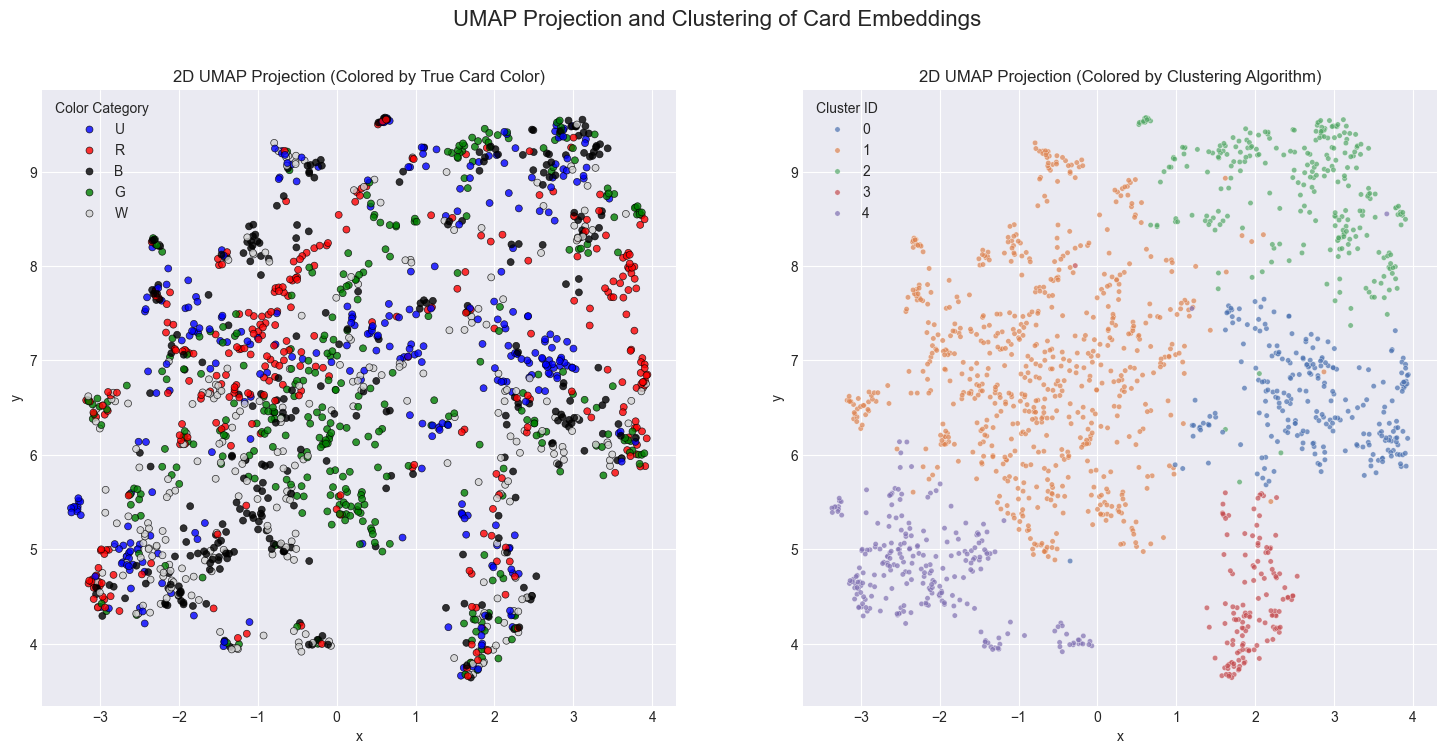

In [40]:
emb_path = (Path("data") / "all-mpnet-base-v2" / "monocol_emb.pkl").resolve()
year = 2017
norm = False
n_neigh_umap = 80
umap_components = 5
spectral_clustering(emb_path, year, norm, n_neigh_umap, umap_components)

Here i spent quite some time manually changing the parameters of the clustering algorithms to see the direction the results went, but the complexity of the task brought results that are not so good.

Now I will try to use another dataset and see if the different embeddings changes the clustering results. I downloaded this dataset form [Hugging Face](https://huggingface.co/datasets/minimaxir/mtg-embeddings) and modified it, adding printing years for all cards (found in raw_data) and adding colors of cards (with regular expresisons), so that previous clustering methods can be applied to this new dataset with minor changes. The download and preparation of the dataset to make it compatible with my already written functions is performed inside data_handler.py

Unique filtered cards printed in 2017 are: 1100
Performing dimensionality reduction with UMAP...


c:\Users\test1\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Clustering the reduced data with Spectral Clustering...

--- Clustering Validation Results ---
Number of clusters found (excluding noise): 5
Fraction of noise points: 0 / 1100
Adjusted Rand Index (ARI): 0.0110
Normalized Mutual Information (NMI): 0.0201
Homogeneity: 0.0184
Completeness: 0.0221
V-Measure: 0.0201

Contingency Matrix (rows=true, cols=predicted):
[[ 84   8  12  72  22]
 [ 93  10  18  85  47]
 [ 77   5  14  88  36]
 [ 55   9  17  75  51]
 [117  10  21  63  11]]
--- End of Validation Report ---

Creating a 2D embedding for visualization...


c:\Users\test1\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\A\UNIVERSITA'\III ANNO\intro ML\MTG_color_pie_clustering\code\clustering.py:228: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.scatterplot(data=vis_df, x='x', y='y', hue='clustered_labels', palette=sns.color_palette("deep", n_colors=n_clusters + 1), s=15, ax=ax2, alpha=0.7)


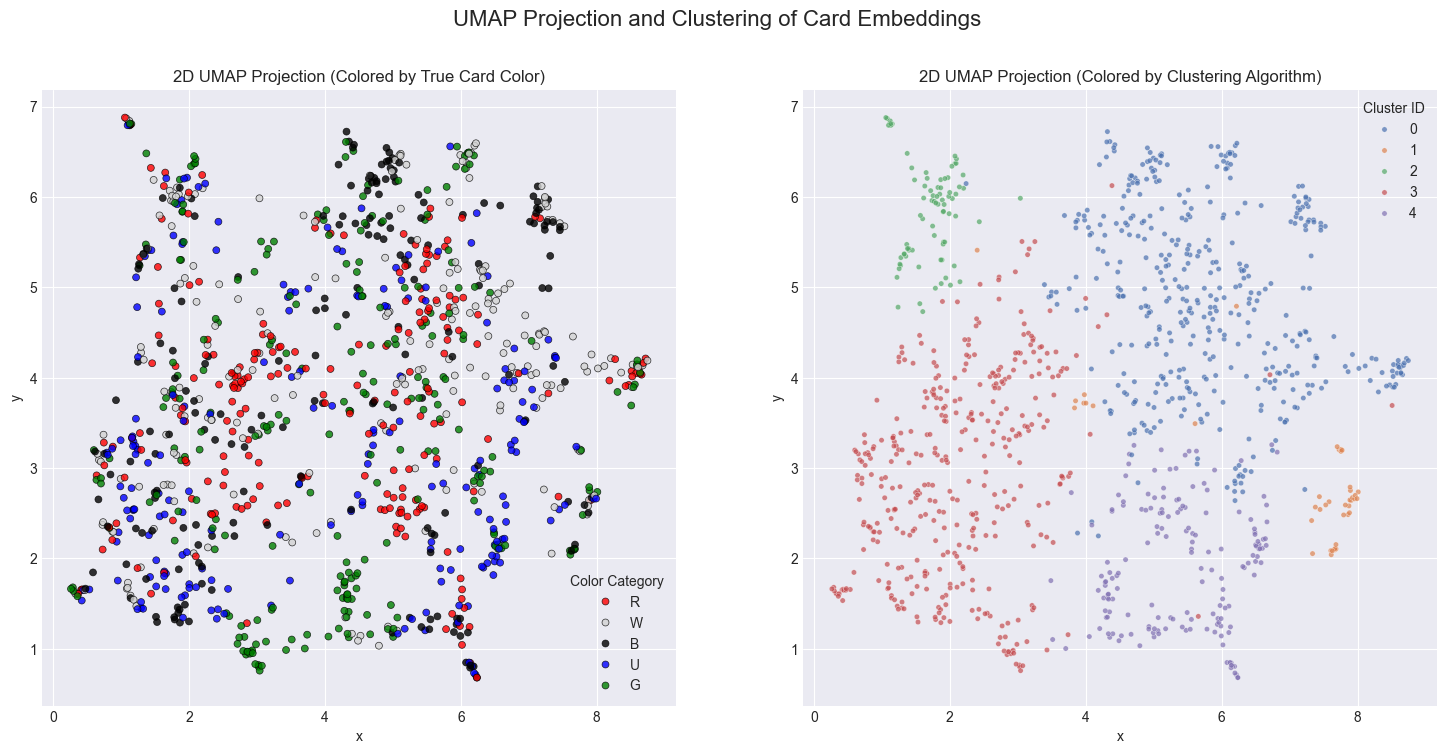

In [6]:
monocol_data_new = (Path("data") / "parquet" / "monocol.parquet").resolve()
year = 2017
norm = False
n_neigh_umap = 12
umap_components = 5
spectral_clustering_v2(monocol_data_new, year, norm, n_neigh_umap, umap_components)